# Discrete Event Simulation

### 1 Simple Discrete Event Simulation
The time between incoming phone calls to customer service is Exponential with a mean of 14 minutes. Each call typically takes min=5, max=20, and most likely = 10 minutes, (Triangularly distributed). Simulate the system based on the following scenarios (run each scenario for 6 hours, with 50 replications).

There are two operators, and the system has only a single queue.

**Report the histogram and mean for the average waiting time.** 

*The average wait time is ~1.13 minutes in this scenario. This is like because the mean exponential distribution of incoming calls is 14 minutes, higher than the mode call length of 10 minutes. The histogram shows there is not much increase in wait time over the simulation time.* 

In [ ]:
#install.packages('simmer')
#install.packages('simmer.plot')

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



The mean wait time is 1.126063 minutes 


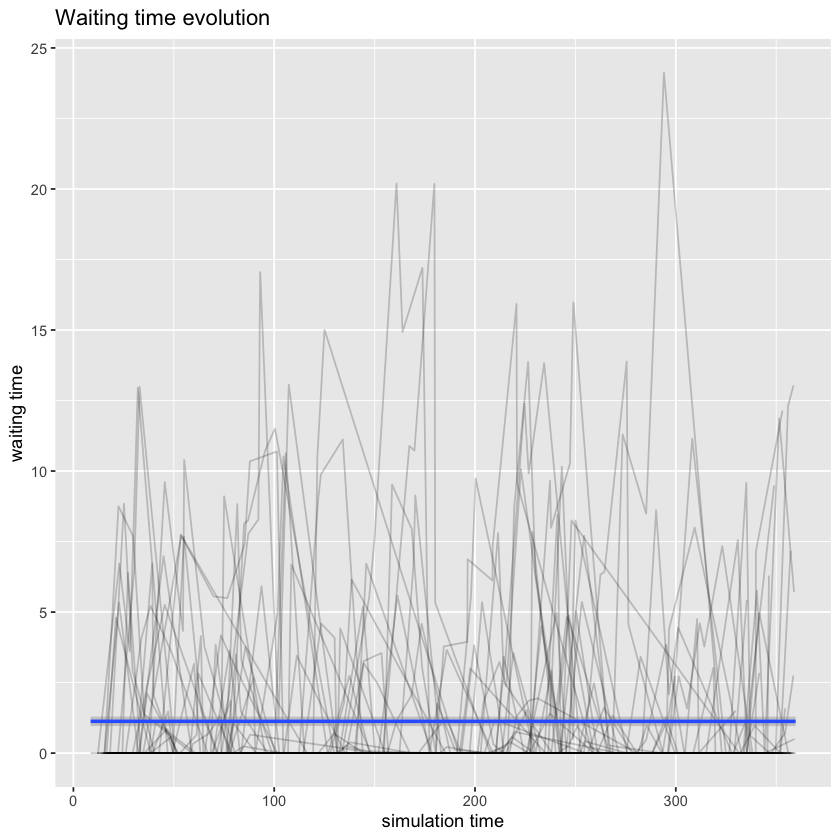

In [6]:
library(simmer)
library(triangle)

set.seed(123)

call <-
  trajectory("Call Routing") %>%
  seize("operator", 1) %>%
  timeout(function() rtriangle(1, 5, 20, 10)) %>%
  release("operator", 1) 

suppressWarnings(library(simmer.plot))

set.seed(123)

envs <- lapply(1:50, function(i) { 
  simmer("Service") %>%
    add_resource("operator", 2) %>%
    add_generator("call", call, function() rexp(1, 1/14)) %>%
    run(360)
  })

resources <- get_mon_resources(envs)

arrivals <- get_mon_arrivals(envs)

plot(arrivals, metric = "waiting_time")

waitTime = (arrivals$end_time - arrivals$start_time) - arrivals$activity_time
cat("The mean wait time is", mean(waitTime, na.rm=T), "minutes \n")

**b) There are two operators, and each operator has its own queue. Phone calls will be directed to the random queue (policy = “random”). Report the histogram and mean for the average waiting time.**

*In this instance the average wait time is 4.12 minutes, with a slight peak in the middle. The likely reason for the increase will be explored in the next segment.*

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



[1] 4.108974

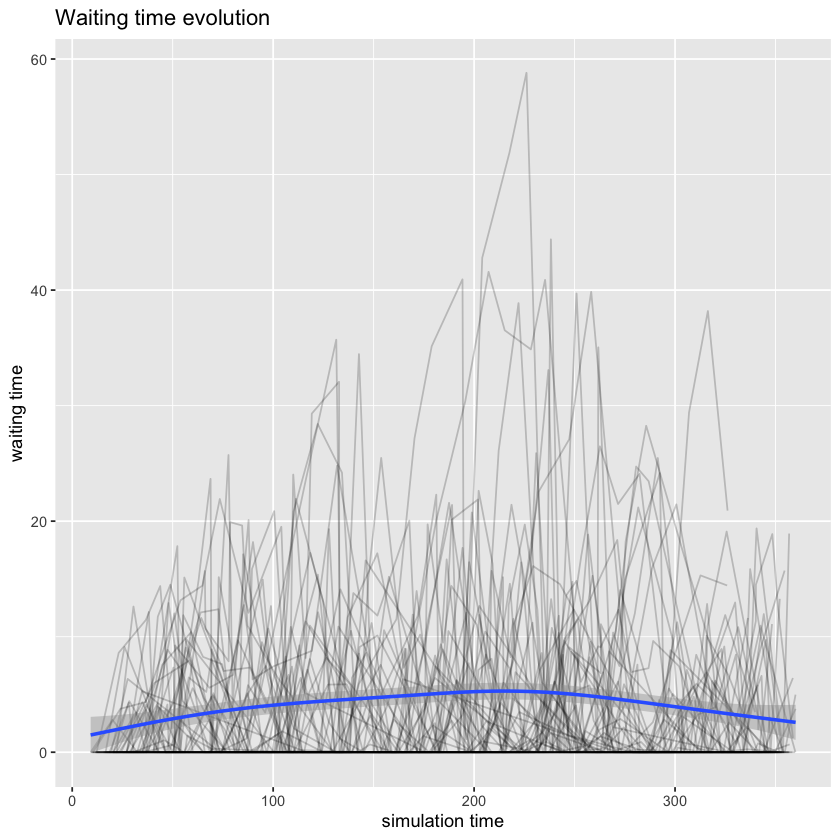

In [7]:
set.seed(123)
call <-
  trajectory("Call Routing") %>%
  select(c("operator1", "operator2"), policy = "random") %>%
  seize_selected() %>%
  timeout(function() rtriangle(1, 5, 20, 10)) %>%
  release_selected

set.seed(123)
envs2 <- lapply(1:50, function(i) {
  simmer("Service") %>%
    add_resource("operator1", 1) %>%
    add_resource("operator2", 1) %>%
    add_generator("call", call, function() rexp(1, 1/14)) %>%
    run(360) })

arrivals3 <- get_mon_arrivals(envs2)
plot(arrivals3, metric = "waiting_time")

waitTime2 = (arrivals3$end_time - arrivals3$start_time) - arrivals3$activity_time
mean(waitTime2)

**c) Compare the average waiting time of parts a and b. Is there any meaningful difference? Explain.**

*The single queue average waiting time is significantly shorter in our simulation has a much shorter confidence interval. In this system, callers are routed to the next available operator as opposed to the multiple queue system where random assignment to a queue means operators are not necessarily being fully utilized. Callers spend more time waiting for their arbitrarily selected operator to be free instead of taking the next available operator. This not only increases wait time, but also gives us a wider confidence interval as the randomness gives us greater variance.*  

2.5%         97.5% 
-1.416645e-15  3.054537e+00

2.5%       97.5% 
 0.07056625 10.13033321

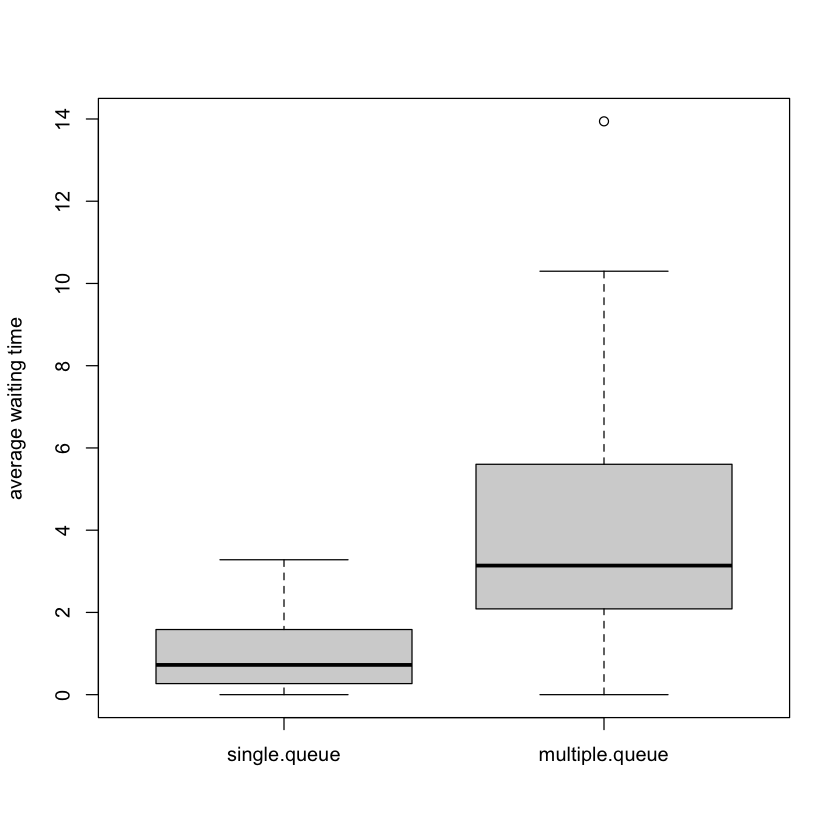

In [8]:
# Single Queue
arrivals2 = cbind(arrivals, waitTime)
xbar = aggregate(arrivals2$waitTime, by = list(arrivals2$replication), FUN = mean)
quantile(xbar$x, c(0.025 , 0.975))

# Multiple Queue
arrivals4 = cbind(arrivals3, waitTime2)
xbar2 = aggregate(arrivals4$waitTime2, by = list(arrivals4$replication), FUN = mean)
quantile(xbar2$x, c(0.025 , 0.975))

# Comparison
boxplot(xbar$x,
        xbar2$x,
        names = c("single.queue", "multiple.queue"),
        ylab = "average waiting time")

### 2 Changing Resource Parameters 
This problem is the revised version of problem 1. Suppose the time between incoming phone calls to customer service is Exponential with a mean of 5 minutes. And, suppose there are 3 operators and each operator has its own queue. Phone calls will be directed to queues randomly. Operators 1 and 2 respond to calls typically between min=5 to max=20 minutes (Uniformly distributed). The third operator is chattier, and her service takes more time, which is Normally distributed with a mean of 15 and a standard deviation of 3 minutes. Run your model for 6 hours, with 50 replications.

**a) Report a utilization plot for each operator. Discuss what you learned from the plot.**

*The plot indicates an expected result from the prompt, the first two operators have a roughly equal and lower utilization than the third operator.*

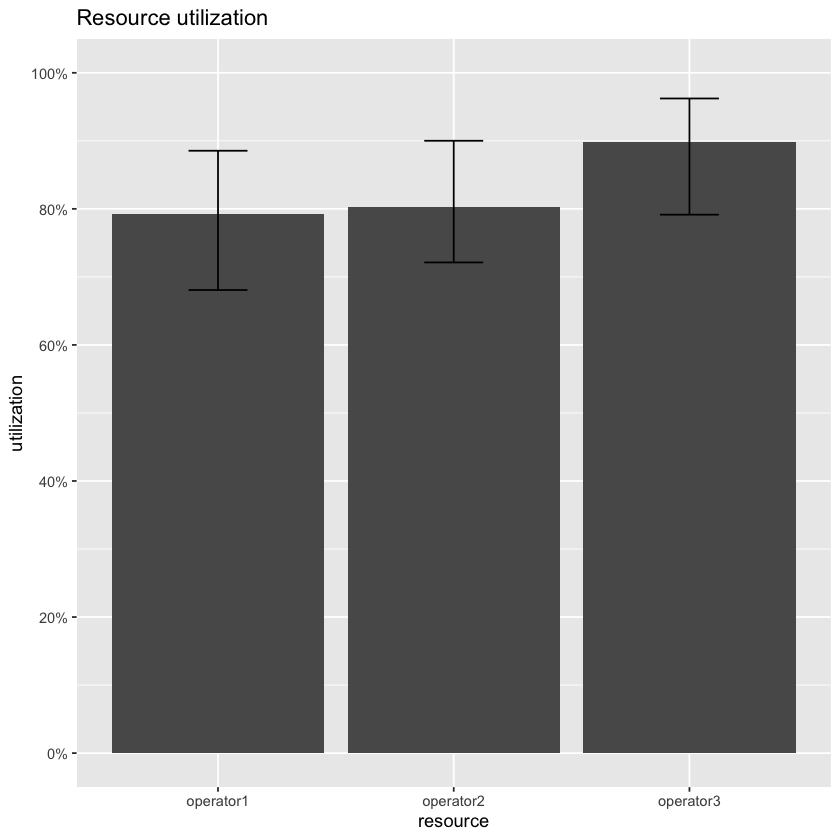

In [9]:
library(simmer)
call <-
  trajectory("Call Routing") %>%
  
  branch(option = function() sample(1:3, 1, replace = T), continue = c(T,T,T),
        trajectory("A") %>% 
        seize("operator1", 1) %>%
        timeout(function() runif(1, 5, 20)) %>%
        release("operator1", 1), 
        
        trajectory("B") %>% 
        seize("operator2", 1) %>%
        timeout(function() runif(1, 5, 20)) %>%
        release("operator2", 1), 
        
        trajectory("C") %>% 
        seize("operator3", 1) %>%
        timeout(function() rnorm(1, 15, 3)) %>%
        release("operator3", 1) 
  )


set.seed(123)
envs <- lapply(1:50, function(i) {
  simmer("Service") %>%
    add_resource("operator1", 1) %>%
    add_resource("operator2", 1) %>%
    add_resource("operator3", 1) %>%
    add_generator("call", call, function() rexp(1, 1/5)) %>%
    run(360)
})

resources <- get_mon_resources(envs)
plot(resources, metric = "utilization")

**b) Report a waiting time for each operator. Discuss your results.**

*The wait time for the third operator is much higher than the first two, who have close average wait times. This is likely due to the third operator's higher utilization and longer call lengths.*

In [10]:
arrivals <- get_mon_arrivals(envs, per_resource = T)

waitTime = (arrivals$end_time - arrivals$start_time) - arrivals$activity_time
arrivals2 = cbind(arrivals, waitTime)
aggregate(arrivals2$waitTime, by = list(arrivals2$resource), FUN=mean)

Group.1,x
<chr>,<dbl>
operator1,15.97817
operator2,18.48356
operator3,24.76400


**c) Find a 95% confidence interval for the average waiting time for each operator.**

*As expected, the 95% confidence interval is wider for the third operator is higher than the first two.*

In [11]:
arrivals2 <- cbind(arrivals, waitTime)

Operator1 <- na.omit(subset(arrivals2, arrivals2$resource == "operator1"))
round(quantile(Operator1$waitTime, c(.025, .975)), 3)

Operator2 <- na.omit(subset(arrivals2, arrivals2$resource == "operator2"))
round(quantile(Operator2$waitTime, c(.025, .975)), 3)

Operator3 <- na.omit(subset(arrivals2, arrivals2$resource == "operator3"))
round(quantile(Operator3$waitTime, c(.025, .975)), 3)

2.5%  97.5% 
 0.000 63.282

2.5%  97.5% 
 0.000 74.303

2.5%  97.5% 
 0.000 77.333

### 3 Machine and Operator Interactions
Consider a manufacturing system comprising two different machines and two operators.

- Each operator is assigned to run a single machine.

- Parts arrive with a Truncated-Normally distributed interarrival time with a min of 0.5 minutes, mean of 4 minutes, and stdev of 2 minutes. The arriving parts are one of two types:

    - Sixty percent of the arriving parts are Type 1 and are processed on Machine 1. These parts require the assigned operator for a 1-minute setup operation.

    - The remaining 40% of the parts are Type 2 and are processed on Machine 2. These parts require the assigned operator for a 1.5-minute setup operation.

- The service times (excluding the setup time) are Normally distributed with a mean of 4.5 minutes and a standard deviation of 1 minute for Type 1 parts and a mean of 7.5 minutes and a standard deviation of 1.5 minutes for Type 2 parts.

- Run your model for 2,000 minutes, with 50 replications.

**a) Plot the utilization, usage, flow_time, and waiting_time. Discuss your findings.**

*Machine 1 has the advantage in setup and service time with a lower mean and standard deviation in their distribution relative to Machine 2. The utilization and usage plots demonstrate the difference, especially regarding queue and system times.*

*The flow and waiting times eventually settle on their means, indicating that this process does not become backed up due to growing queues over time. *

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



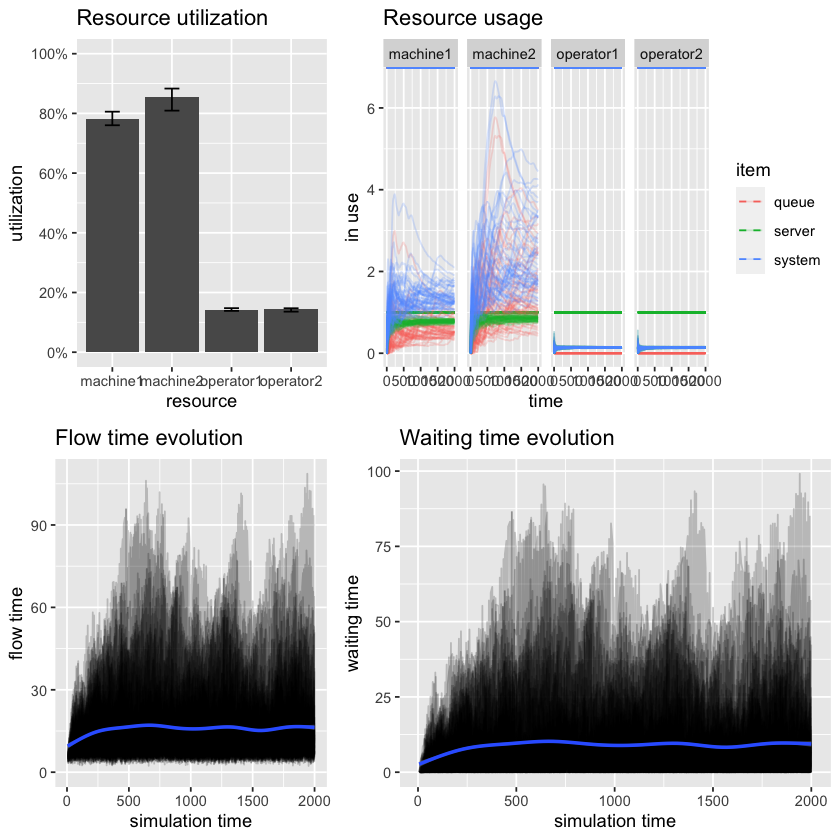

In [21]:
suppressWarnings(library(simmer))
suppressWarnings(library(truncnorm))
suppressWarnings(library(gridExtra))
suppressWarnings(library(simmer.plot))

part <- trajectory("Part Path" ) %>%

branch(option = function() sample(1:2, 1, prob = c(0.6, 0.4), replace=T), continue = c(T),

  trajectory("A") %>%
    set_attribute("type", 1) %>%
    seize("machine1", 1) %>%
    seize("operator1", 1) %>%
    timeout(1) %>%
    release("operator1", 1) %>%
    timeout(function() rnorm(1, 4.5, 1)) %>%
    release("machine1", 1),

  trajectory("B") %>%
    set_attribute("type", 2) %>%
    seize("machine2", 1) %>%
    seize("operator2", 1) %>%
    timeout(1.5) %>%
    release("operator2", 1)%>%
    timeout(function() rnorm(1, 7.5, 1.5)) %>%
    release("machine2", 1)
)

envs <- lapply(1:50, function(i) {
  simmer("Man") %>%
    add_resource("operator1", 1) %>%
    add_resource("operator2", 1) %>%
    add_resource("machine1", 1) %>%
    add_resource("machine2", 1) %>%
    add_generator("part", part, function() rtruncnorm(1, a=0.5, mean=4, sd=2), mon = 2) %>%
    run(2000)
  })

resources = get_mon_resources(envs)
arrivals = get_mon_arrivals(envs)

p1 = plot(resources, metric = "utilization")
p2 = plot(resources, metric = "usage")
p3 = plot(arrivals, metric = "flow_time")
p4 = plot(arrivals, metric = "waiting_time")

# Increase the width of the resource usage plot for legibility 
grid.arrange(p1, p2, p3, p4, nrow = 2, ncol = 2, widths = c(1, 1.5), heights = c(1, 1))

**b) Report the average total time spent in the system (flow time) for each type of part.**

*The flow time for Machine 2's Type 2 parts is over twice as long as Type 1/Machine 1.* 

In [22]:
x1 <- get_mon_arrivals(envs)
x2 <- get_mon_attributes(envs)
merged <- merge(x1, x2, by = c("name", "replication"), all = T)

TypeA <- subset(merged, merged$value == 1)
TypeB <- subset(merged, merged$value == 2)

typeA.flowTime = (TypeA$end_time-TypeA$start_time)
cat("Flow time for Type 1 parts:", mean(typeA.flowTime, na.rm = T), "\n")

typeB.flowTime = (TypeB$end_time-TypeB$start_time)
cat("Flow time for Type 2 parts:", mean(typeB.flowTime, na.rm = T))

Flow time for Type 1 parts: 9.8402 
Flow time for Type 2 parts: 24.65721

### 4 DES Priority Setting, Leaving, and Reneging in Medical Triage

Consider an Urgent Care (UC) comprising three doctors and one nurse to serve patients during the day.

- On a typical day, the interarrival time is Exponentially distributed with a mean of 6 minutes.
- 25% of patients are high-priority, and the remaining are low-priority.
- Upon arrival at UC, the patients are triaged by a nurse into one of the two types of patients. The service time for triage is distributed by Triangular distribution with min = 3, max = 10, and the most likely value = 5 minutes.
- Then, the patients wait in the waiting room and get called to visit doctors on a first- come-first-served basis. If more than 10 people are waiting for service, an arriving patient will exit before being triaged.
- Finally, low-priority patients may depart if they have to wait longer than 20±5 minutes (Uniformly distributed) after triage.

The doctor service time distributions are given as follows:

| Priority | Service Time Distribution (Minutes) |
|----------|-------------------------------------|
| High     | Normal(mean=40,sd=5)                |
| Low      | Gamma(shape=15,rate=1)              |

Assuming that the UC opens at 8 hours, simulate the process for 50 replications.

**(a) Estimate the average flow time of each type of patient.**

*The average flow times are 45.4 minutes for low priority patients, and 53.4 minutes for high priority patients. Low priority patients likely have a lower flow time because they will renege (depart) if they wait too long. The length of time they are willing to wait is simulated by a uniform distribution between 15-25 minutes.*

In [23]:
suppressWarnings(library(simmer))
suppressWarnings(library(triangle))

set.seed(123)

envs <- lapply(1:50, function(i) {
  env <- simmer("Clinic") %>%
    add_resource("nurse", 1) %>%
    add_resource("doctor", 3)

  patient <- trajectory("Patient Path") %>%

    branch(function()
      sample(1:2, size=1, replace=TRUE, prob=c(0.25,0.75)), continue=c(T,T),
      
      # High Priority
      trajectory("High Priority") %>%
        set_attribute("priority", 2) %>%
        set_prioritization(c(5, 7, T)) %>%
        
        # Patient leaves if combined queues of nurse and doctor > 10   
        leave(prob = function()
          ifelse((get_queue_count(env, "nurse")+ get_queue_count(env, "doctor"))>10, 1, 0)) %>%
        
        # Nurse triage time is a tringular distribution with min 3, max 10, and mode of 5 minutes      
        seize("nurse", 1) %>%
        timeout(function() rtriangle(1, 3, 10, 5)) %>%
        release("nurse", 1) %>%
        
        # Low priority doctor service time is normally distributed with a mean of 40 and sd of 5        
        seize("doctor", 1) %>%
        timeout(function() rnorm(1, 40, 5)) %>%
        release("doctor", 1),
      
      # Low Priority
      trajectory("Low Priority") %>%
        set_attribute("priority", 1) %>%
        set_prioritization(c(3, 7, T)) %>%
        
        # Patient leaves if combined queues of nurse and doctor > 10         
        leave(prob = function()
          ifelse((get_queue_count(env, "nurse")+ get_queue_count(env, "doctor"))>10, 1, 0)) %>%
              
        seize("nurse", 1) %>%
        timeout(function() rtriangle(1, 3, 10, 5)) %>%
        release("nurse", 1) %>%
      
        # Renege for wait time 15-25
        renege_in(function() runif(1, 15, 25), out = trajectory()) %>%
        
        # Seize doctor if not aborted by renege          
        seize("doctor", 1) %>%
        renege_abort() %>%
        # High priority doctor service time is a gamma distribution with a shape of 15 and rate of 1 
        timeout(function() rgamma(1, 15, 1)) %>%
        release("doctor", 1)
    )
  # Generate patients arriving in exponential distribution with mean of 6 minutes                
  env %>%
    add_generator("patient", patient, function() rexp(1, 1/6), mon = 2)

  env %>%
    run(480)
})

In [24]:
x1 <- get_mon_arrivals(envs)
x2 <- get_mon_attributes(envs)
all <- merge(x1, x2, by=c("name", "replication"), all = T)
all <- na.omit(all)

# Low Priority flow time
Type1 <- subset(all, all$value == 1)
type1.flowTime = (Type1$end_time-Type1$start_time)

# High Priority flow time
Type2 <- subset(all, all$value == 2)
type2.flowTime = (Type2$end_time-Type2$start_time)

cat("Low Priority Average Flow Time: ", mean(type1.flowTime, na.rm = T), "\n")
cat("High Priority Average Flow Time: ", mean(type2.flowTime, na.rm = T))

Low Priority Average Flow Time:  45.38219 
High Priority Average Flow Time:  53.42489

**(b) Estimate the probability that low-priority patients balk.**

*Balking is when a patient or customer decides not to join a queue that is too long. Our scenario specified that patients will leave if more than 10 people in the queue, which is captured by the `leave()` function in our model.*

*In our simulation, the probability of low-priority patients balking is 2.8%*

In [25]:
cat("Probability of low-priority patient balk: ", mean(all$activity_time==0 & all$value==1))

Probability of low-priority patient balk:  0.02777778